# Things that need preparing
## CHANGE_SSL_METHOD
### change_for_archiecture

* old resnet **DONE**
* new resnet **DONE**

****

### SSL methods used

* Barlow_twins
* simsiam
* supcon
* swav

****

## Domain adaptation 
* MNISIT
* MNISIT_MIX


In [1]:
import wandb

from utils.util import BCE, PairEnum, cluster_acc, Identity, AverageMeter, seed_torch,accuracy
from data.cifarloader import CIFAR10Loader, CIFAR10LoaderMix, CIFAR100Loader, CIFAR100LoaderMix
from models.resnet import ResNet, BasicBlock
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, lr_scheduler
import numpy as np
from tqdm import tqdm
import pandas as pd


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# all these conditions for cifar 10 
seed_torch(0)
num_labeled_classes=5
num_unlabeled_classes=5
num_classes = num_labeled_classes + num_unlabeled_classes
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
api = wandb.Api()# used to import weight and bias pipeline


## STEP 3
## Change of architecutre

In [15]:
## STEP 1
run_old_SSL = api.run("mhaggag96/trends_project/1ni39qdj").history()
run_new_SSL = api.run("mhaggag96/trends_project/1o6drm9k").history()
run_old_SSL_model = 'data/experiments/selfsupervised_learning/rotnet_cifar10_basicconfig.pth'
run_new_SSL_model = 'data/experiments/selfsupervised_learning/rotnet_cifar10_new_config.pth'



### analysis on SSL step 

In [7]:
from selfsupervised_learning import resnet_sim
from models.resnet import BasicBlock
from selfsupervised_learning import test


In [10]:
global is_adapters  # TODO: Does anyone know what is the use of this??? what happens if I change its value ????
is_adapters = 0
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # Initial Convolution + BatchNormalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Append ResNet18 layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Implement a final linear layer to classify between the given classes. This head will be used only to perform
        # this unsupervised classification task (RotNet), and will be removed in the next task (Supervised training)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        # If is_adapters is true then add a parallel_convolution layer
        if is_adapters:  # Not used since adapters is set to 0
            self.parallel_conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, bias=False)

    def _make_layer(self, block, planes, num_blocks, stride):
        # Compute a strides list for the different blocks. Use the input argument stride for the first block
        # (this allows to reduce the dimension if it is >1), then use stride=1 for all the other layers in the block
        strides = [stride] + [1] * (num_blocks - 1)
        # Define an empty list of layers
        layers = []
        # Each layer is composed of a set of blocks with the previously defined strides
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion  # Block expansion is set to 1 in the BasicBlock class
        return nn.Sequential(*layers)

    def forward(self, x):
        # Compute the output of the NN
        # If is adapters is true consider also the parallel convolution in the computation of the output
        if is_adapters:  # TODO:How is is_adapters used and defined??
            out = F.relu(self.bn1(self.conv1(x) + self.parallel_conv1(x)))
        # Otherwise consider just the previous layers
        else:
            out = F.relu(self.bn1(self.conv1(x)))
        # Compute the output through all the ResNet layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [19]:
from data.rotationloader import DataLoader, GenericDataset
dataset_test = GenericDataset(
            dataset_name='cifar10',
            split='test',
            dataset_root='./data/datasets/CIFAR/'
        )
dloader_test = DataLoader(
            dataset=dataset_test,
            batch_size=64,
            num_workers=4,
            shuffle=False)

Files already downloaded and verified


In [17]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=4)
model.load_state_dict(torch.load(run_old_SSL_model))
model_2 = resnet_sim(num_labeled_classes=4)
model_2.load_state_dict(torch.load(run_new_SSL_model))

<All keys matched successfully>

In [20]:
def test(model, device, dataloader, epoch):
    # Define an instance of AverageMeter to compute and store the average and current values of the accuracy
    acc_record = AverageMeter()
    # Put the model in evaluation mode
    model.eval()
    # Iterate through the dataloader using tqdm to print a graphic progress bar
    for batch_idx, (data, label) in enumerate(tqdm(dataloader())):
        # Move both data and label to gpu, the data has input (256,3,32,32)
        data, label = data.to(device), label.to(device)
        # Compute the output of the model for the input data. Output dimension (256,4)
        output = model(data)

        # Compute the accuracy using the accuracy() function from the file utils.py
        # Also in this call the argument 'topk' is not passed, so it is set to default value of (1,)
        acc = accuracy(output, label)
        # Update the accuracy AverageMeter object with the values just computed
        acc_record.update(acc[0].item(), data.size(0))

    # Print the result of the testing procedure
    print('Test Acc: {:.4f}'.format(acc_record.avg))
    return acc_record

In [22]:
model.to(device)
acc_record = test(model, device, dloader_test, 0)


100%|█████████████████████████████████████████| 157/157 [00:07<00:00, 19.99it/s]

Test Acc: 96.0850


In [24]:
model_2.to(device)
acc_record = test(model_2, device, dloader_test, 0)


100%|█████████████████████████████████████████| 157/157 [00:07<00:00, 20.83it/s]

Test Acc: 95.5500


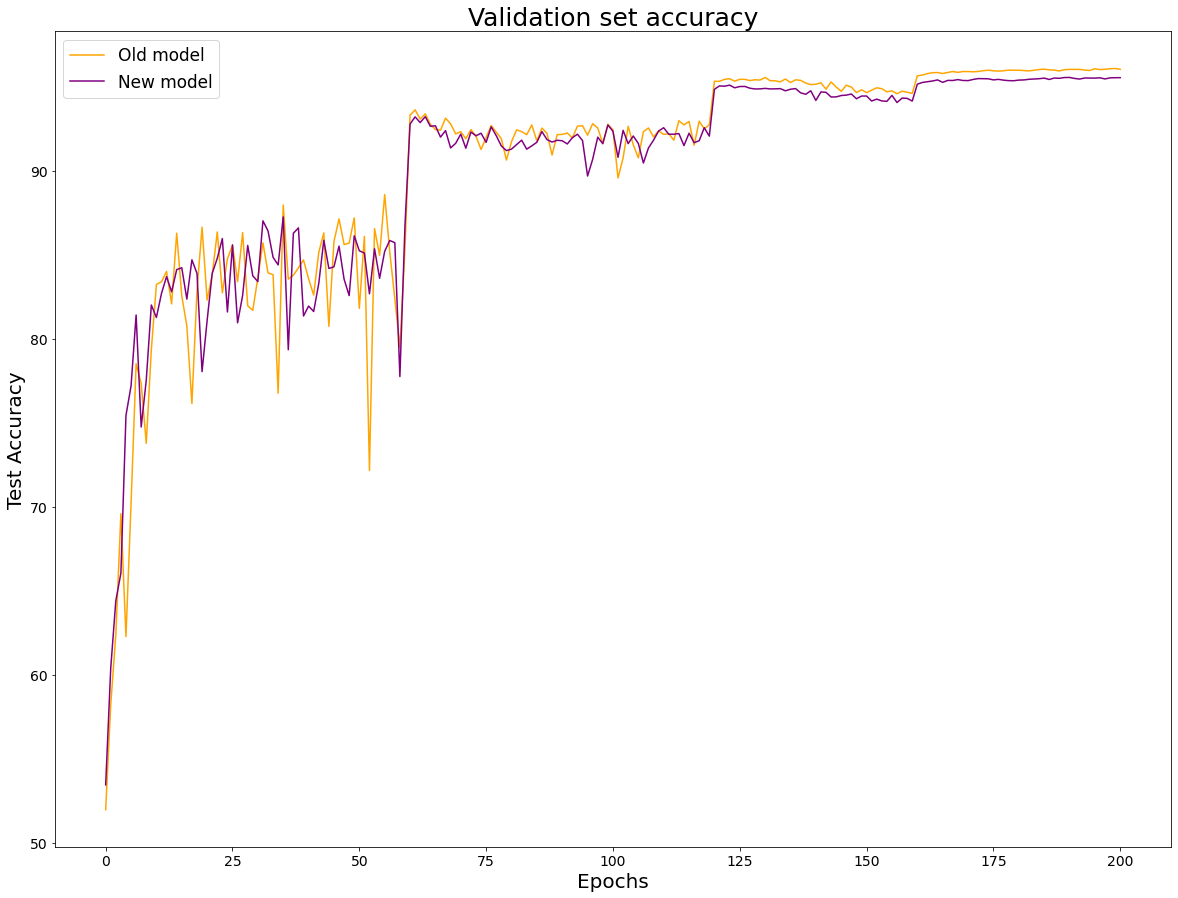

In [27]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SSL.Head_1_val_accuracy.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SSL.Head_1_val_accuracy.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

### anaylsis of SL

In [33]:
from models.resnet import BasicBlock,resnet_sim,ResNet
from utils.util import cluster_acc, Identity, AverageMeter, accuracy
from data.cifarloader import CIFAR10Loader, CIFAR10LoaderMix,

In [ ]:
## STEP 2
run_old_SL = api.run("mhaggag96/trends_project/vp78kjp8").history()
run_new_SL = api.run("mhaggag96/trends_project/2sderoky").history()
run_old_SL_model = 'data/experiments/supervised_learning/resnet_rotnet_cifar10_basicconfig.pth'
run_new_SL_model = 'data/experiments/supervised_learning/resnet_rotnet_cifar10_new_config.pth'

In [32]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.load_state_dict(torch.load(run_old_SL_model))
model_2 = resnet_sim(5, 5).to(device)
model_2.load_state_dict(torch.load(run_new_SL_model))

<All keys matched successfully>

In [42]:
def test(model, test_loader):
    model.eval()
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter()  # track the accuracy of the first head

    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        x, label = x.to(device), label.to(device)
        output1, output2, _ = model(x)
        output = output1
        _, pred = output.max(1)
        acc_testing = accuracy(output, label)  # calculating the accuracy
        acc_record.update(acc_testing[0].item(), x.size(0))
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets,
                                                                                                              preds)
    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari, acc_record.avg))
    return acc, nmi, ari, acc_record.avg

In [43]:
labeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                            aug=None, shuffle=False, target_list=range(5))

In [44]:
acc_H1, nmi_H1, ari_H1, acc_testing_H1 =test(model, labeled_eval_loader)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 34.53it/s]


Test cluster acc 0.9584, nmi 0.8694, ari 0.8994, test accuracy 95.8400


In [45]:
acc_H1, nmi_H1, ari_H1, acc_testing_H1 =test(model_2, labeled_eval_loader)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 35.61it/s]

Test cluster acc 0.9476, nmi 0.8421, ari 0.8744, test accuracy 94.7600


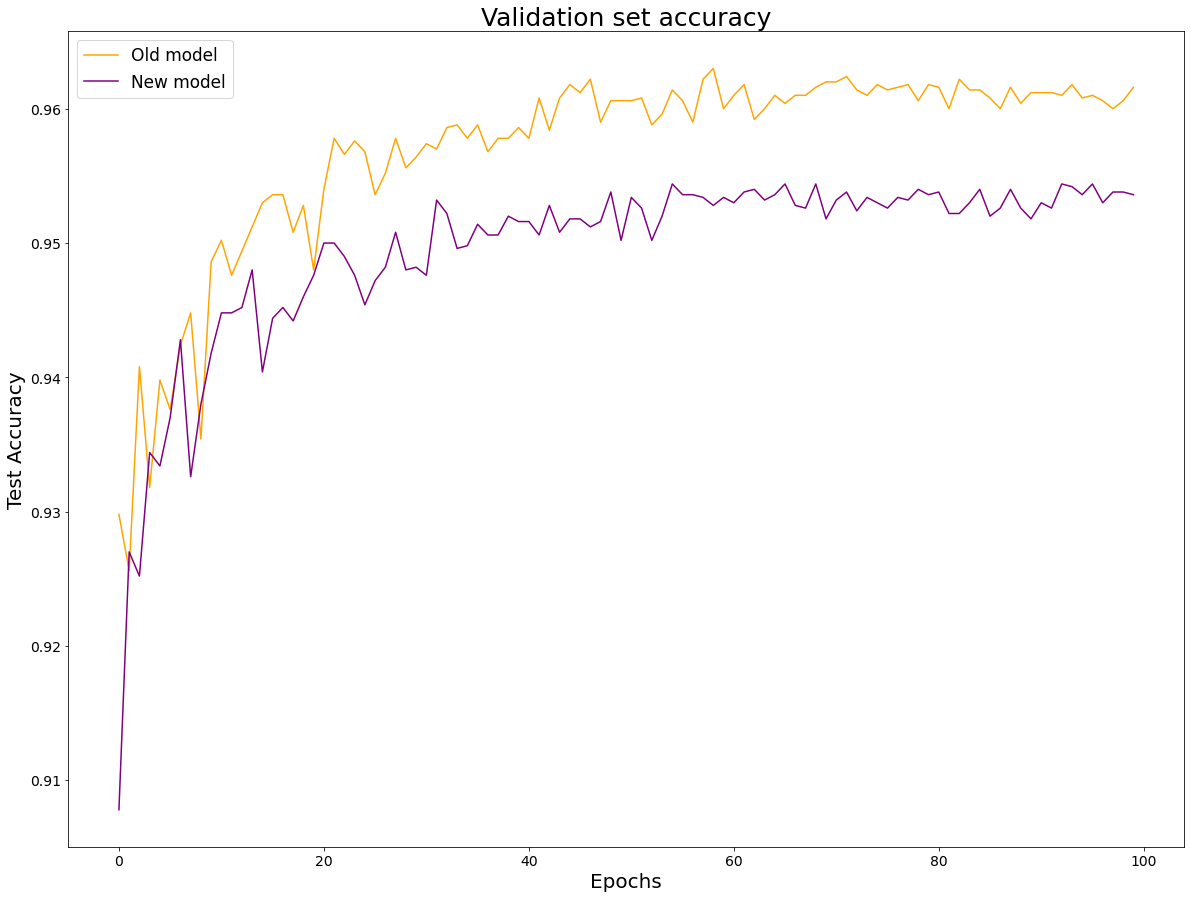

In [48]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SL.cluster_acc_Head_1.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SL.cluster_acc_Head_1.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

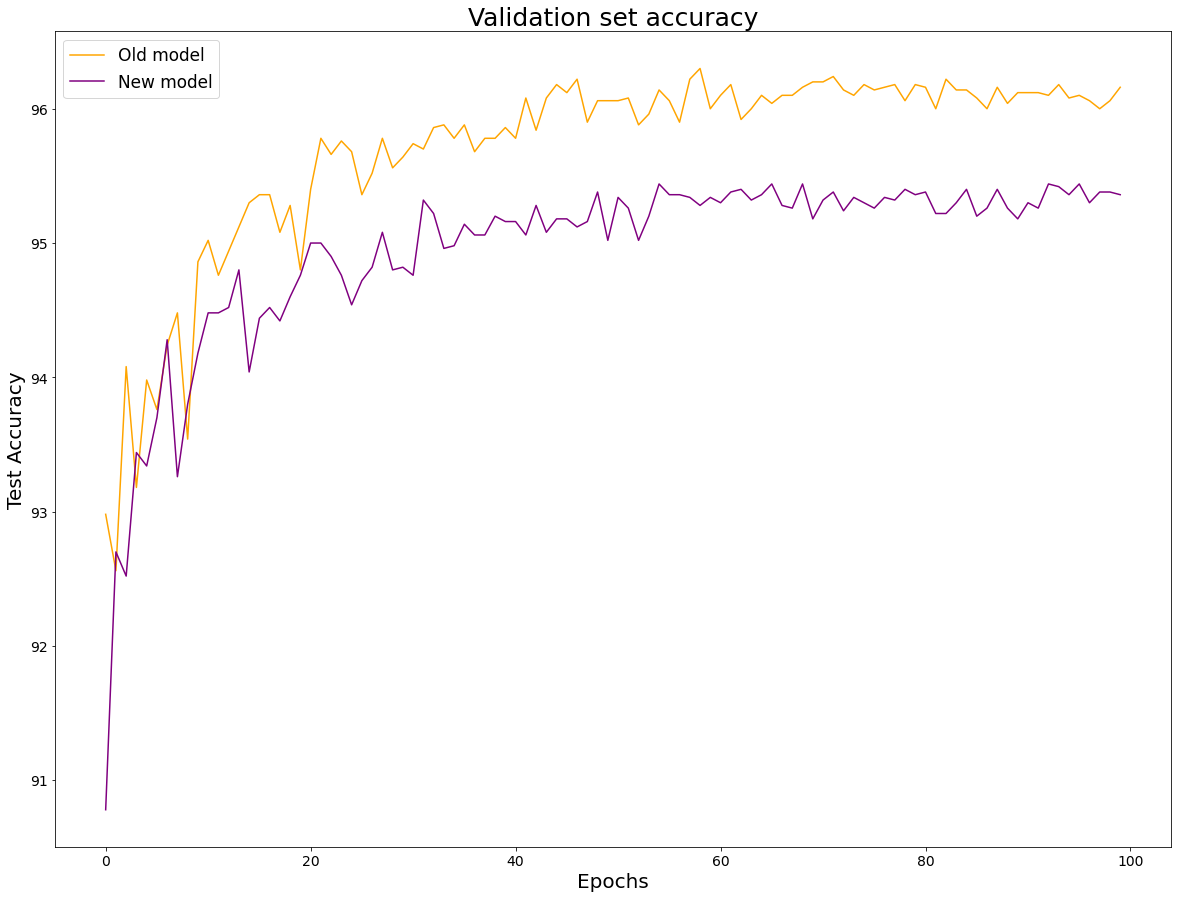

In [47]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SL.testing_acc_Head_1.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SL.testing_acc_Head_1.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

### analysis of NCD

In [49]:
## STEP 3
run_old_NCL = api.run("mhaggag96/trends_project/1ggpmba1").history()
run_new_NCL = api.run("mhaggag96/trends_project/2wov4ow5").history()
run_old_NCL_model = 'data/experiments/auto_novel/resnet_IL_cifar10_basic_config.pth'
run_new_NCL_model = 'data/experiments/auto_novel/resnet_IL_cifar10_new_config.pth'

In [63]:


def test(model, test_loader,args):
    # Put the model in evaluation mode
    model.eval()
    # Instantiate two numpy arrays, one for predictions and oen for targets
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter()  # track the accuracy of the first head
    # loss_record = AverageMeter()

    # Iterate for each batch in the dataloader
    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        # Dataloader contain: X(input sample), label(sample label), index(index of sample in the original dataset)
        # We are interested in using just the sample x and its label to perform supervised learning
        x, label = x.to(device), label.to(device)

        # Output 1, Output2 and Output3 are the results of Head1, Head2, and features-layer4 respectively, we take the
        # outputs of the two heads since we are interested in testing the accuracy of one of the two
        output1, output2, _ = model(x)

        # If the argument head is 'head1' then we take as final output the result of the supervised head
        if args['head'] == 'head1':
            # output1 has size of (128,5), since the batch_size is 128 and the possible classes are 5
            output = output1
        # Otherwise, we take as final output the result of the unsupervised head
        else:
            output = output2
            # label-=args.num_labeled_classes

        # Returns the maximum value for each element in the input tensor, therefore we move from size (128,5) to (128)
        # Here we are not interested in the value, so we put '_' for the first term. We are interested in the second
        # term, which is the index of that value, since the index is equal to the predicted class for that input sample.
        _, pred = output.max(1)

        # Convert tensor to numpy using 'X.cpu.numpy', then append the value in the respective numpy array
        if args['head'] == 'head1':
            acc_testing = accuracy(output, label)  # calculating the accuracy
            acc_record.update(acc_testing[0].item(), x.size(0))
        else:
            acc_testing = 0
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())

    # Compute the accuracy metrics for the current test step, see supervised_learning.py for full explanation
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets,
                                                                                                              preds)

    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari, acc_record.avg))
    return acc, nmi, ari, acc_record.avg

In [54]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load(run_old_NCL_model))
model_2 = resnet_sim(5, 5).to(device)
model_2.head1 = nn.Linear(512, 10).to(device)
model_2.load_state_dict(torch.load(run_new_NCL_model))

<All keys matched successfully>

In [69]:
unlabeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='train',
                                              aug=None, shuffle=False,
                                              target_list=range(5, 10))
unlabeled_eval_loader_test = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                                   aug=None, shuffle=False,
                                                   target_list=range(5, 10))
labeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                            aug=None, shuffle=False, target_list=range(5))

In [70]:
args={"head":"head2"}

In [71]:
args['head']

'head2'

In [73]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 37.31it/s]

Test cluster acc 0.9202, nmi 0.8320, ari 0.8201, test accuracy 0.0000


(0.9202, 0.8320104161918431, 0.8201387124443089, 0)

In [67]:
test(model, unlabeled_eval_loader_test,  args)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 34.55it/s]

Test cluster acc 0.9146, nmi 0.8220, ari 0.8069, test accuracy 0.0000


(0.9146, 0.8219752618659001, 0.8068902802256295, 0)

In [72]:
test(model_2, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 38.50it/s]

Test cluster acc 0.9030, nmi 0.7918, ari 0.7812, test accuracy 0.0000


(0.90296, 0.7918218103415373, 0.7812178564442299, 0)

In [68]:
test(model_2, unlabeled_eval_loader_test,  args)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 34.94it/s]

Test cluster acc 0.8970, nmi 0.7822, ari 0.7681, test accuracy 0.0000


(0.897, 0.7821943685816475, 0.7680634247203061, 0)

In [74]:
run_old_NCL

,ari_Head_2,ari_Head_1,cluster_acc_Head_1,_step,Cross_entropy_loss,nmi_Head_2,_runtime,lr,epoch,nmi_Head_1,Consistency_loss_total,testing_acc_Head_1,Total_average_loss,Binary_cross_entropy_loss,incremental_loss,cluster_acc_Head_2,Consistency_loss_part_a,Consistency_loss_part_b,_timestamp,Head_1_training_accuracy
0,0.438937,0.827704,0.9268,0,0.220721,0.480703,41,0.10,0,0.801632,0.011511,92.68,0.473514,0.249547,0.002859,0.67592,0.009678,0.001833,1670930617,92.400182
1,0.442140,0.842369,0.9332,1,0.161070,0.487670,77,0.10,1,0.811801,0.012517,93.32,0.413534,0.248205,0.003744,0.68564,0.009643,0.002874,1670930653,94.250109
2,0.418374,0.845834,0.9348,2,0.148835,0.453391,112,0.10,2,0.813436,0.012692,93.48,0.400975,0.246999,0.004508,0.68008,0.009554,0.003138,1670930688,94.717343
3,0.437402,0.861781,0.9418,3,0.132861,0.470747,147,0.10,3,0.830930,0.013303,94.18,0.385541,0.246563,0.005316,0.70000,0.009822,0.003481,1670930723,95.370590
4,0.418312,0.853575,0.9384,4,0.116332,0.467638,182,0.10,4,0.822918,0.013677,93.84,0.370370,0.246784,0.006260,0.69316,0.009847,0.003830,1670930758,95.938325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.808541,0.876882,0.9322,195,0.005699,0.818132,6869,0.01,195,0.832977,0.002243,93.22,0.266933,0.241826,0.008193,0.91512,0.001795,0.000448,1670937445,99.942283
196,0.806849,0.878580,0.9324,196,0.005903,0.818364,6903,0.01,196,0.836010,0.002284,93.24,0.267114,0.241877,0.007911,0.91460,0.001830,0.000455,1670937479,99.920861
197,0.821318,0.874720,0.9296,197,0.005085,0.824919,6938,0.01,197,0.830903,0.002238,92.96,0.265887,0.241804,0.007807,0.92024,0.001783,0.000455,1670937514,99.923257
198,0.807194,0.878340,0.9326,198,0.005276,0.818974,6973,0.01,198,0.834502,0.002162,93.26,0.265115,0.241669,0.007358,0.91476,0.001713,0.000449,1670937549,99.903845


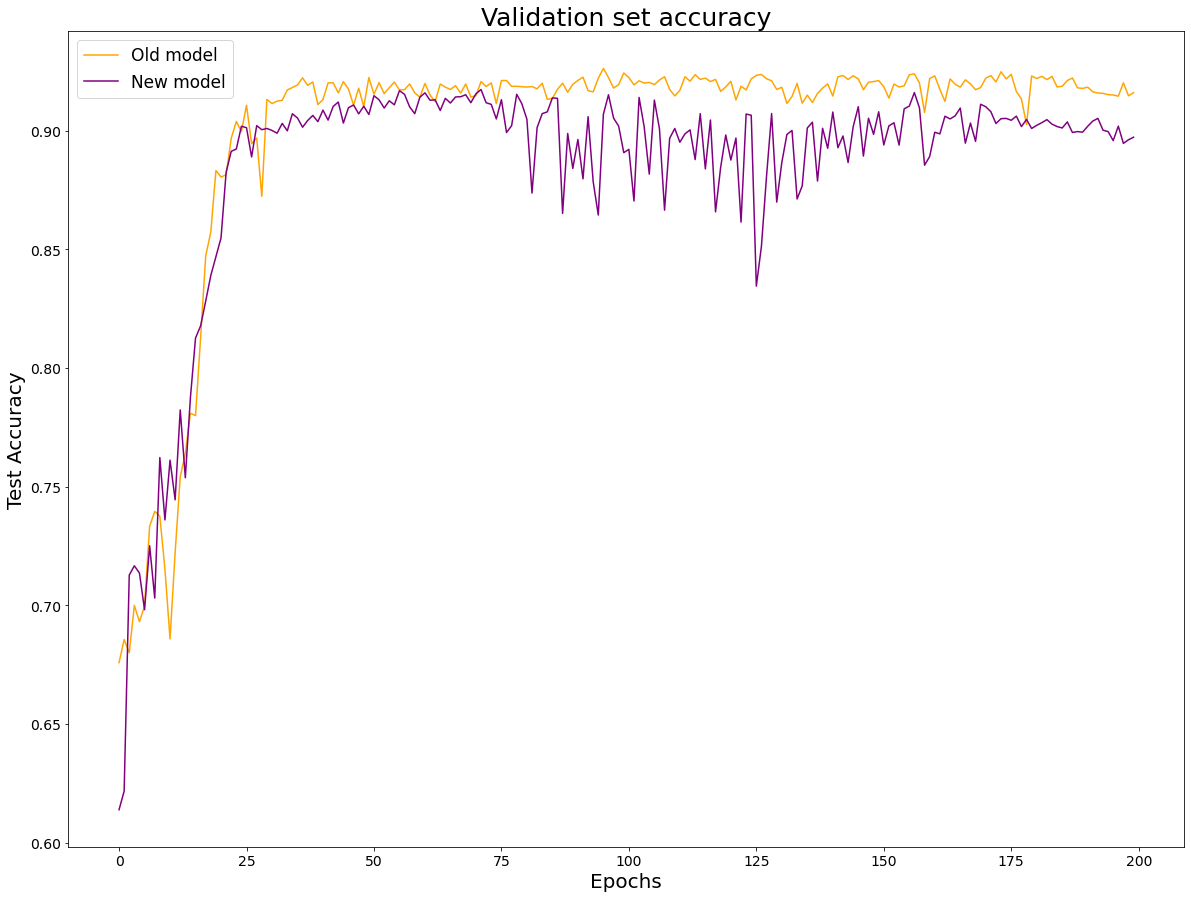

In [75]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_NCL.cluster_acc_Head_2.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_NCL.cluster_acc_Head_2.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

## SSL methods


In [ ]:
run_old_SL           = api.run("").history()# to run it now 
run_NCD_rotnet       = api.run("").history()# 93_baseline_AN_new_resnet
run_NCD_barlow_twins = api.run("").history()
run_NCD_simsiam      = api.run("").history()
run_NCD_supcon       = api.run("").history()
run_NCD_swav         = api.run("").history()
